# Baseline Forecasts

Recall from our regression lessons that an important step in predictive modeling is establishing a baseline for comparison purposes. Let's introduce a few options for time series forecasting.

## What we will accomplish

In this notebook we will:
- Introduce six baseline models:
    - Forecasts for data without trend or seasonality:
        - An average or white noise forecast and
        - A naive or random walk forecast,
    - Forecasts for data with trend but not seasonality:
        - A trend forecast and
        - A random walk with drift forecast,
    - Forecasts for data with seasonality but not trend:
        - A seasonal average forecast and
        - A seasonal trend forecast
- And discuss error measurement for forecasting.

### Notation

Throughout this notebook we will assume that $y_t$ is a time series, that the training set has $n$ observations and that we are interested in predicting observations at times $t > n$.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from seaborn import set_style
from sklearn.metrics import mean_squared_error

set_style("whitegrid")

#### Two data sets

We will illustrate these forecasts on two data sets. The first is Google's parent company's closing stock price for each trading day from August 19, 2004 to March 25, 2022. This data set comes from <a href="https://finance.yahoo.com/">Yahoo! Finance</a>. The second data set are the weekly seasonal influenza case counts for the United States of America from 1931 to 1950 provided by <a href="https://www.tycho.pitt.edu/">Project Tycho</a>.

## Data without trend or seasonality

The first two forecasts are reasonable baselines for data that do not exhibit a trend or seasonality.

We will demonstrate their implementation with some Google stock data, even though it appears to exhibit a trend.

#### Predicting Google stock prices

The data we load below gives the Google parent company stock closing price on every trading day from August 19, 2004 to March 25, 2022.

In [2]:
## Load the data
goog = pd.read_csv("../../data/google_stock.csv", parse_dates=['date'])

In [3]:
## First five entries
goog.head()

,date,closing_price
0,2004-08-19,49.982655
1,2004-08-20,53.952770
2,2004-08-23,54.495735
3,2004-08-24,52.239197
4,2004-08-25,52.802086


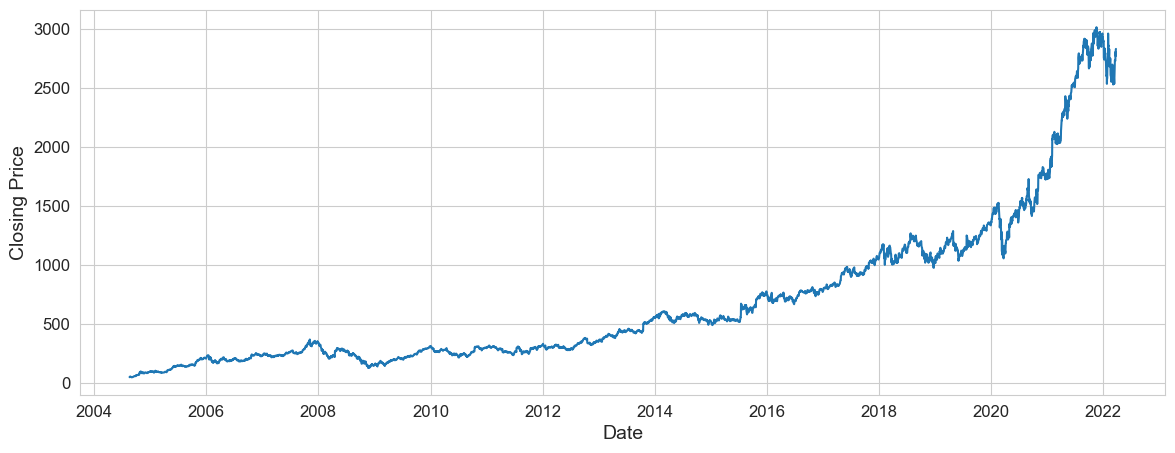

In [4]:
plt.figure(figsize=(14,5))

plt.plot(goog.date, goog.closing_price)

plt.xlabel("Date", fontsize=14)
plt.ylabel("Closing Price", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

We will build baseline models that forecast the closing price for the next two weeks.

For simplicity, we will <i>not</i> be performing cross-validation, we will just compare both models to the last 14 trading days in the data set.

In [5]:
goog_train = goog.iloc[:-14].copy()
goog_test = goog.iloc[-14:].copy()

### An average forecast

One baseline is the <i>average forecast</i> which consists of predicting the historical average for every time point in the horizon.

Formally our forecast is:

$$
f(t) = \left\lbrace \begin{array}{l c c} E(y_t) + \epsilon, & \text{for} & t > n  \\
                                        y_t & \text{for} & t\leq n
                                        \end{array}\right.,
$$

where $\epsilon$ is an error term and in practice we estimate $E(y_t)$ with:

$$
\frac{1}{n}\sum_{i=1}^n y_i.
$$

<i>Note for this estimate to be "good" the assumption that the $y_t$ are independent and identically distributed</i>.

#### White noise

The model underlying this forecast assumes that the time series is a purely random process consisting of a sequence of independent identically distributed random variables. In time series such a sequence is often referred to as <i>white noise</i>.

In [6]:
## Making the average "prediction"
goog_avg = goog_train.closing_price.mean()*np.ones(len(goog_test))

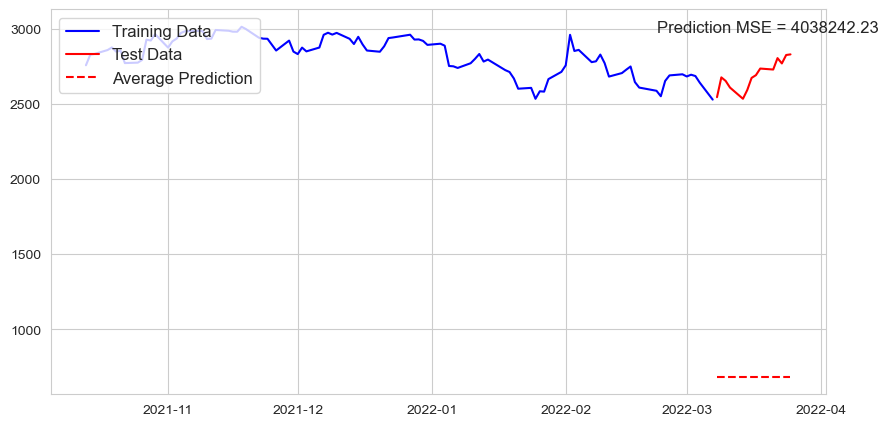

In [7]:
## Plotting the average prediction with the actual data
plt.figure(figsize=(10, 5))

plt.plot(goog_train.date[-100:],
            goog_train.closing_price[-100:],
            'b-',
            label="Training Data")

plt.plot(goog_test.date,
            goog_test.closing_price,
            'r-',
            label="Test Data")

plt.plot(goog_test.date,
            goog_avg,
            'r--',
            label="Average Prediction")

plt.text(goog_train.date.values[-10],
         2980,
         "Prediction MSE = " + str(np.round(mean_squared_error(goog_test.closing_price.values,
                                                                  goog_avg), 2)),
         fontsize=12)

plt.legend(fontsize=12, loc=2)

plt.show()

### A naive forecast

Another baseline you may consider is the <i>naive forecast</i>. In this model your prediction for the entire horizon is just the value of the final observation in your data set.

Formally our forecast is:

$$
f(t) = \left\lbrace \begin{array}{l c c}y_n + \epsilon, & \text{for} & t > n  \\
                                        y_t & \text{for} & t\leq n
                                        \end{array}\right.,
$$

where $\epsilon$ is an error term.

#### Random walks

The underlying statistical model for this forecast is the <i>random walk</i> where a sequence of random variables, $y_1, y_2, \dots$ are given be:

$$
y_0 = c, \ c \in \mathbb{R} \ \ \text{ and } \ \ y_{t+1} = y_{t} + \epsilon.
$$

In [8]:
## Making the naive "prediction"
goog_naive = goog_train.closing_price.values[-1]*np.ones(len(goog_test))

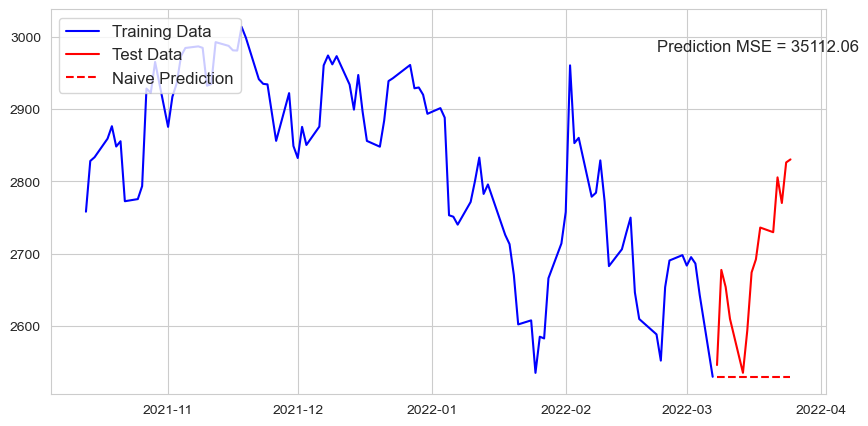

In [9]:
## Plotting the naive prediction with the actual data
plt.figure(figsize=(10,5))

plt.plot(goog_train.date[-100:],
            goog_train.closing_price[-100:],
            'b-',
            label="Training Data")

plt.plot(goog_test.date,
            goog_test.closing_price,
            'r-',
            label="Test Data")

plt.plot(goog_test.date,
            goog_naive,
            'r--',
            label="Naive Prediction")

plt.text(goog_train.date.values[-10],
         2980,
         "Prediction MSE = " + str(np.round(mean_squared_error(goog_test.closing_price.values,
                                                                  goog_naive), 2)),
         fontsize=12)

plt.legend(fontsize=12, loc=2)

plt.show()

We can see that neither forecast is particularly good, but one is certainly better than the other. This could help color your decision of baseline model. For example, the average model is a poor baseline for this data set because the Google stock price has risen dramatically since its initial public offering, note that this sort of behavior is called a <i>trend</i>.

## Data with trend but no seasonality

These two forecasts can serve as decent baselines for data sets with a trend but no seasonality.

Again we will demonstrate with the Google data set.

### A trend forecast

A baseline trend forecast will assume that the time series is a linear function of time plus some random noise, i.e.:

$$
f(t) = \left\lbrace \begin{array}{l c c} \beta_0 + \beta_1 t + \epsilon, & \text{for} & t > n  \\
                                        y_t & \text{for} & t\leq n
                                        \end{array}\right.,
$$

where $\beta_0, \beta_1 \in \mathbb{R}$ and $\epsilon$ is a random error term.

#### Underlying statistical model

Here the statistical model is similar to white noise, but instead of the random variables being independent of time we assume that the expectation of the random variable is linear in time, i.e. $E(y_t) = \beta_0 + \beta_1 t$. We can think of this as a trend extension of the average model described above.

#### Fitting the model

To estimate $\beta_0, \ \beta_1$ we can fit a linear regression model using the time point as the feature you are regressing on.

In [10]:
## import linear regression
from sklearn.linear_model import LinearRegression

In [11]:
## Make the model object
reg = LinearRegression()

## Fit the model
reg.fit(np.arange(1, len(goog_train) + 1).reshape(-1,1),
        goog_train.closing_price)

## Make the forecast
trend_pred = reg.predict(np.arange(len(goog_train)+1, len(goog_test) + len(goog_train) + 1).reshape(-1,1))

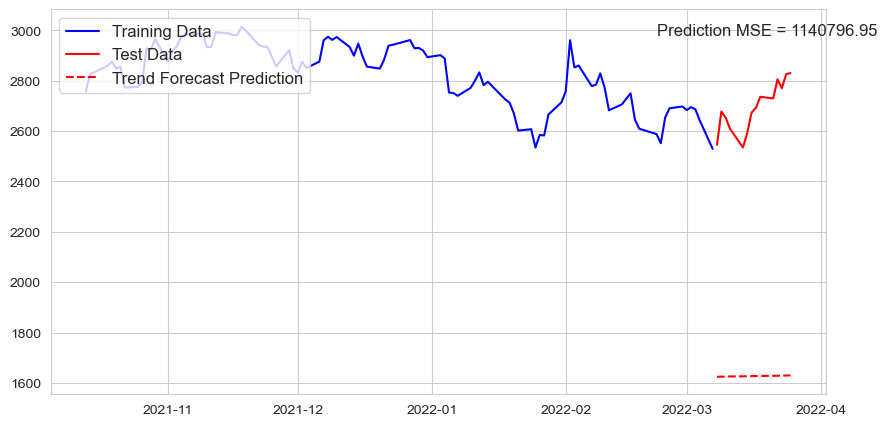

In [12]:
## Plotting the naive prediction with the actual data
plt.figure(figsize=(10,5))

plt.plot(goog_train.date[-100:],
            goog_train.closing_price[-100:],
            'b-',
            label="Training Data")

plt.plot(goog_test.date,
            goog_test.closing_price,
            'r-',
            label="Test Data")

plt.plot(goog_test.date,
            trend_pred,
            'r--',
            label="Trend Forecast Prediction")

plt.text(goog_train.date.values[-10],
         2980,
         "Prediction MSE = " + str(np.round(mean_squared_error(goog_test.closing_price.values,
                                                                  trend_pred), 2)),
         fontsize=12)

plt.legend(fontsize=12, loc=2)

plt.show()

While this is still not a great fit, it is an improvement on the average model.

### A random walk with drift

This forecast is an extension of the naive forecast from above:

$$
f(t) = \left\lbrace \begin{array}{l c c} y_n + \beta(t-n) + \epsilon, & \text{for} & t > n  \\
                                        y_t & \text{for} & t\leq n
                                        \end{array}\right.,
$$

where $\beta \in \mathbb{R}$ and $\epsilon$ is random noise.

#### Underlying statistical model

The model underlying this forecast is known as a <i>random walk with drift</i> where a sequence of random variables, $y_1, y_2, \dots$ are given be:

$$
y_0 = c, \ c \in \mathbb{R} \ \ \text{ and } \ \ y_{t+1} = y_{t} + \beta + \epsilon.
$$

#### Estimating $\beta$

We can estimate $\beta$ with the arithmetic mean of the <i>first differences</i>. First differences are produced by calculating $y_{t+1} - y_t$, and can be quickly calculated using `pandas` `.diff()` `DataFrame` function.

In [13]:
goog_train.closing_price.head()

0    49.982655
1    53.952770
2    54.495735
3    52.239197
4    52.802086
Name: closing_price, dtype: float64

In [14]:
## demonstrate .diff()
goog_train.closing_price.diff().head()

0         NaN
1    3.970115
2    0.542965
3   -2.256538
4    0.562889
Name: closing_price, dtype: float64

In [15]:
beta_hat = goog_train.closing_price.diff().mean()

drift_pred = goog_train.closing_price.values[-1] + beta_hat*np.arange(1,len(goog_test) + 1)

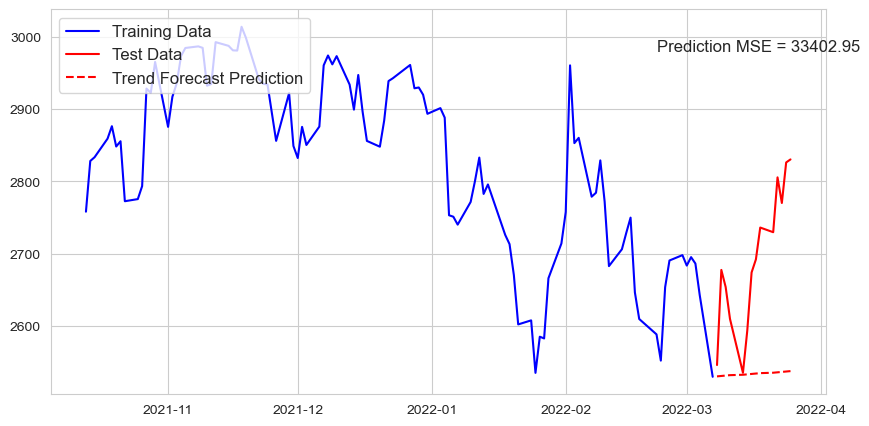

In [16]:
## Plotting the naive prediction with the actual data
plt.figure(figsize=(10,5))

plt.plot(goog_train.date[-100:],
            goog_train.closing_price[-100:],
            'b-',
            label="Training Data")

plt.plot(goog_test.date,
            goog_test.closing_price,
            'r-',
            label="Test Data")

plt.plot(goog_test.date,
            drift_pred,
            'r--',
            label="Trend Forecast Prediction")

plt.text(goog_train.date.values[-10],
         2980,
         "Prediction MSE = " + str(np.round(mean_squared_error(goog_test.closing_price.values,
                                                                  drift_pred), 2)),
         fontsize=12)

plt.legend(fontsize=12, loc=2)

plt.show()

Probably our best baseline so far.

## Data with seasonality but no trend

These forecasts may be useful for baseline comparisons on data with seasonality but no trend.

We will demonstrate how these models are implemented with a seasonal influenza data set.

#### Predicting US seasonal influenza incidence

Let's visualize the influenza data set now.

In [17]:
flu = pd.read_csv("../../data/us_flu_1928_1948.csv", parse_dates=['date'])

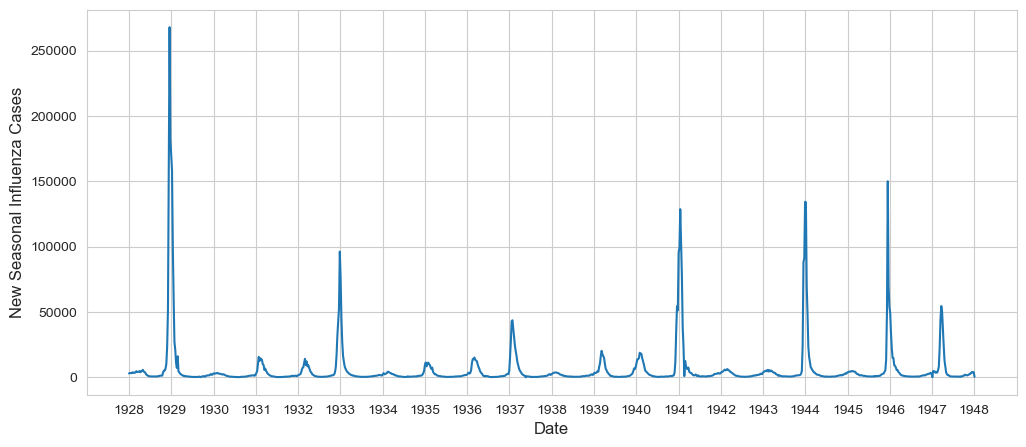

In [18]:
plt.figure(figsize=(12,5))

plt.plot(flu.date, flu.cases)

plt.xlabel("Date", fontsize=12)
plt.ylabel("New Seasonal Influenza Cases", fontsize=12)

plt.xticks([datetime(1928,1,1) + timedelta(days=365*i) for i in range(21)],
           [str(i) for i in range(1928, 1949)],
           fontsize=10)
plt.yticks(fontsize=10)

plt.show()

As we can see, this data exhibits a yearly pattern. New cases tend to increase at the end or beginning of each year and peak in the first quarter, declining afterward. This cycle occurs on a yearly basis. Time series that exhibit this kind of behavior are said to exhibit <i>seasonality</i>.

When we believe that our time series is seasonal we can use this knowledge to update our previous baseline models in an attempt to improve them.

We will use our two models to predict the new influenza cases in each week of 1947.

In [19]:
flu_train = flu.loc[flu.year!=1947].copy()
flu_test = flu.loc[flu.year==1947].copy()

## Seasonal average forecast

For each time step in the horizon the <i>seasonal average forecast</i> predicts the average value over all corresponding points in the season from the training set.

For example, to predict the new cases week $17$ of 1947 we would find the average value of all week $17$s that occur in our data set.

Formally our model is:

$$
f(t) = \left\lbrace \begin{array}{l c c}\frac{1}{\left\lfloor n/m \right\rfloor + 1} \sum_{i=0}^{\left\lfloor n/m \right\rfloor} y_{t\%m + i*m} + \epsilon, & \text{for} & t > n  \\
                                        y_t & \text{for} & t\leq n
                                        \end{array}\right.,
$$

where $\lfloor \bullet \rfloor$ again denotes the floor function, $\%$ denotes modular division and $\epsilon$ is an error term.

#### Underlying statistical model

This is a seasonal extension of the average forecast from above. The underlying model assumes that each step in the season represents its own white noise sequence, whose expected value we estimate with step wise arithmetic means.

In [20]:
flu_train.head()

,date,year,week,cases
0,1928-01-01,1928,1,2938
1,1928-01-08,1928,2,3343
2,1928-01-15,1928,3,3208
3,1928-01-22,1928,4,3118
4,1928-01-29,1928,5,3743


In [21]:
## get the average model predictions
flu_avg = []

for week in range(1,53):
    flu_avg.append(flu_train.loc[flu_train.week==week].cases.mean())

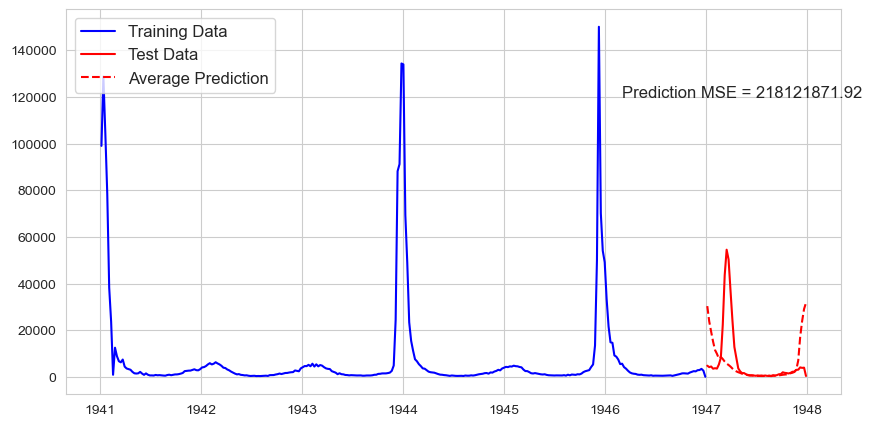

In [22]:
## Plotting the naive prediction with the actual data

plt.figure(figsize=(10,5))

plt.plot(flu_train.date.values[-6*52:],
            flu_train.cases.values[-6*52:],
            'b-',
            label="Training Data")

plt.plot(flu_test.date,
            flu_test.cases,
            'r-',
            label="Test Data")

plt.plot(flu_test.date,
            flu_avg,
            'r--',
            label="Average Prediction")

plt.text(datetime(1946, 3,1),
         120000,
         "Prediction MSE = " + str(np.round(mean_squared_error(flu_test.cases.values,
                                                                  flu_avg), 2)),
         fontsize=12)

plt.legend(fontsize=12, loc=2)

plt.show()

## Seasonal naive model

For each time step in the forecast horizon the <i>seasonal naive forecast</i> predicts the value from the corresponding point in the most recent season of the training data.

To be precise, suppose that a "season" for the time series is $m$ time steps. Then our model is:

$$
f(t) = \left\lbrace \begin{array}{l c c}y_\tau + \epsilon, & \text{for} & t > n  \\
                                        y_t & \text{for} & t\leq n
                                        \end{array}\right.,
$$

where 

$$
\tau = t - \left(\left\lfloor \frac{t - n}{m} \right\rfloor + 1\right) m, \text{ with } \lfloor \bullet \rfloor \text{ denoting the floor function and}
$$

$\epsilon$ is an error term.

For example, if $m=6$, $n=12$ and $t=19$, then you would predict the value at step $7$, or $y_7$.

#### Underlying model

This is a seasonal extension of the random walk model, where we can think of each step in the season's cycle as its own random walk sequence.

#### Cycle length for influenza data 

Influenza has a season equivalent to about $1$ year, or approximately $52$ weeks (this data set has been cleaned so that each year has $52$ weeks). To demonstrate the model we will predict influenza cases in the final year of the data set. So for our model we will just need to use the value in each corresponding week in 1949.

In [23]:
flu_naive = flu_train.loc[flu_train.year == 1946].cases.values

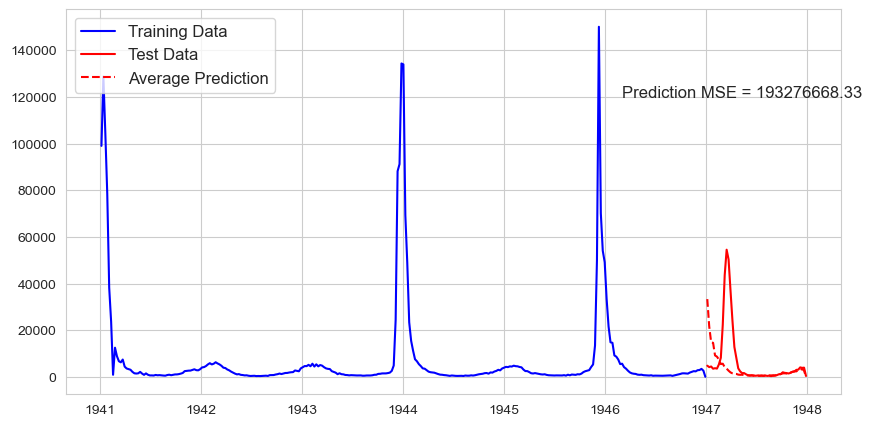

In [24]:
## Plotting the naive prediction with the actual data
plt.figure(figsize=(10,5))

plt.plot(flu_train.date[-6*52:],
            flu_train.cases[-6*52:],
            'b-',
            label="Training Data")

plt.plot(flu_test.date,
            flu_test.cases,
            'r-',
            label="Test Data")

plt.plot(flu_test.date,
            flu_naive,
            'r--',
            label="Average Prediction")

plt.text(datetime(1946, 3,1),
         120000,
         "Prediction MSE = " + str(np.round(mean_squared_error(flu_test.cases.values,
                                                                  flu_naive), 2)),
         fontsize=12)

plt.legend(fontsize=12, loc=2)

plt.show()

Again we can see that neither of these forecasts are particularly good. In this case the reason is twofold. First the height of the peak of flu season is not consistent. Sometimes you will have mild seasons and other times you will have harsh seasons. Peak occurrence is also inconsistent. Some seasons the peak occurs before the new year, while it occurs after the new year in others.

## Wrapping up

You now have six baselines to choose from depending on your data. While we did not cover baseline options for time series that exhibit both a trend and seasonality, there are extensions of the white noise and random walk models that can be used to produce forecasts for such data. This extension is left to the corresponding `Practice Problems` notebook.

--------------------------

This notebook was written for the Erd&#337;s Institute C&#337;de Data Science Boot Camp by Matthew Osborne, Ph. D., 2023.

Any potential redistributors must seek and receive permission from Matthew Tyler Osborne, Ph.D. prior to redistribution. Redistribution of the material contained in this repository is conditional on acknowledgement of Matthew Tyler Osborne, Ph.D.'s original authorship and sponsorship of the Erdős Institute as subject to the license (see License.md)